In [1]:
import colorsys
import matplotlib.colors as mcolors
import numpy as np
from PIL import Image, ImageDraw
import torch
from torchvision import transforms
import os 
import cv2

In [2]:
if torch.cuda.is_available() and torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [ ]:


SAPIENS_LITE_MODELS_PATH = {
    "depth": {
        "sapiens_0.3b": "checkpoints/depth/sapiens_0.3b_torchscript.pt2",
        "sapiens_0.6b": "checkpoints/depth/sapiens_0.6b_torchscript.pt2",
        "sapiens_1b": "checkpoints/depth/sapiens_1b_torchscript.pt2",
    },
    "detector": {},
    "normal": {
        "sapiens_0.3b": "checkpoints/normal/sapiens_0.3b_torchscript.pt2",
        "sapiens_0.6b": "checkpoints/normal/sapiens_0.6b_torchscript.pt2",
        "sapiens_1b": "checkpoints/normal/sapiens_1b_torchscript.pt2",
    },
    "pose": {
        "sapiens_0.3b": "checkpoints/pose_coco/sapiens_0.3b_torchscript.pt2",    # sapiens_0.3b_coco_best_coco_AP_796_torchscript.pt2
        "sapiens_0.6b": "checkpoints/pose_coco/sapiens_0.6b_torchscript.pt2",    # sapiens_0.6b_coco_best_coco_AP_812_torchscript.pt2
        "sapiens_1b": "checkpoints/pose_coco/sapiens_1b_torchscript.pt2"         # sapiens_1b_coco_best_coco_AP_821_torchscript.pt2
    },
    "seg": {
        "sapiens_0.3b": "checkpoints/seg/sapiens_0.3b_torchscript.pt2",
        "sapiens_0.6b": "checkpoints/seg/sapiens_0.6b_torchscript.pt2",
        "sapiens_1b": "checkpoints/seg/sapiens_1b_torchscript.pt2",
    }
}

LABELS_TO_IDS = {
    "Background": 0,
    "Apparel": 1,
    "Face Neck": 2,
    "Hair": 3,
    "Left Foot": 4,
    "Left Hand": 5,
    "Left Lower Arm": 6,
    "Left Lower Leg": 7,
    "Left Shoe": 8,
    "Left Sock": 9,
    "Left Upper Arm": 10,
    "Left Upper Leg": 11,
    "Lower Clothing": 12,
    "Right Foot": 13,
    "Right Hand": 14,
    "Right Lower Arm": 15,
    "Right Lower Leg": 16,
    "Right Shoe": 17,
    "Right Sock": 18,
    "Right Upper Arm": 19,
    "Right Upper Leg": 20,
    "Torso": 21,
    "Upper Clothing": 22,
    "Lower Lip": 23,
    "Upper Lip": 24,
    "Lower Teeth": 25,
    "Upper Teeth": 26,
    "Tongue": 27,
}

In [11]:
def show2DposeCoCo(kps, img):
    
    if not isinstance(img, np.ndarray):
        img = np.array(img)
        
    # # OpenCV에서 사용할 수 있도록 RGB -> BGR 변환
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
    connections = [[0, 1], [1, 3], [0, 2], [2, 4], 
                   [15, 13], [13, 11], [11, 5], [5, 7], [7, 9], 
                   [16, 14], [14, 12], [12, 6], [6, 8], [8, 10],
                   [6, 5] 
                ]

    # LR = np.array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], dtype=bool)
    LR = [-1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, -1, -1]

    lcolor = (255, 0, 0)
    rcolor = (0, 0, 255)
    ccolor = (0, 150, 0)
    thickness = 3

    for j,c in enumerate(connections):
        start = map(int, kps[c[0]])
        end = map(int, kps[c[1]])
        start = list(start)
        end = list(end)
        cv2.line(img, (start[0], start[1]), (end[0], end[1]), lcolor if LR[j] == 1 else (rcolor if LR[j] == 0 else ccolor), thickness)
        cv2.circle(img, (start[0], start[1]), thickness=-1, color=(0, 255, 0), radius=3)
        cv2.circle(img, (end[0], end[1]), thickness=-1, color=(0, 255, 0), radius=3)

    return img

In [12]:
def resize_image(pil_image, target_size):
    """
    Resize a PIL image while maintaining its aspect ratio.

    Args:
    pil_image (PIL.Image): The input image.
    target_size (tuple): The target size as (width, height).

    Returns:
    PIL.Image: The resized image.
    """
    original_width, original_height = pil_image.size
    target_width, target_height = target_size

    # Calculate aspect ratios
    aspect_ratio = original_width / original_height
    target_aspect = target_width / target_height

    if aspect_ratio > target_aspect:
        # Image is wider than target, scale based on width
        new_width = target_width
        new_height = int(new_width / aspect_ratio)
    else:
        # Image is taller than target, scale based on height
        new_height = target_height
        new_width = int(new_height * aspect_ratio)

    # Resize the image
    resized_image = pil_image.resize((new_width, new_height), Image.LANCZOS)

    # Create a new image with the target size and paste the resized image
    new_image = Image.new('RGB', target_size, (0, 0, 0))
    paste_x = (target_width - new_width) // 2
    paste_y = (target_height - new_height) // 2
    new_image.paste(resized_image, (paste_x, paste_y))

    return new_image


def get_pose(image, pose_estimator, input_shape=(3, 1024, 768), device="cuda"):
    # Preprocess the image
    img = preprocess_image(image, input_shape)

    # Run the model
    with torch.no_grad():
        heatmap = pose_estimator(img.to(device))

    # Post-process the output
    keypoints, keypoint_scores = udp_decode(heatmap[0].cpu().float().numpy(),
                                            input_shape[1:],
                                            (input_shape[1] // 4, input_shape[2] // 4))

    # Scale keypoints to original image size
    scale_x = image.width / input_shape[2]
    scale_y = image.height / input_shape[1]
    keypoints[:, 0] *= scale_x
    keypoints[:, 1] *= scale_y

    # Visualize the keypoints on the original image
    # pose_image = visualize_keypoints(image, keypoints, keypoint_scores)
    pose_image = show2DposeCoCo(keypoints, image)
    return pose_image

def preprocess_image(image, input_shape):
    # Resize and normalize the image
    img = image.resize((input_shape[2], input_shape[1]))
    img = np.array(img).transpose(2, 0, 1)
    img = torch.from_numpy(img).float()
    img = img[[2, 1, 0], ...] # RGB to BGR
    mean = torch.tensor([123.675, 116.28, 103.53]).view(3, 1, 1)
    std = torch.tensor([58.395, 57.12, 57.375]).view(3, 1, 1)
    img = (img - mean) / std
    return img.unsqueeze(0)

def udp_decode(heatmap, img_size, heatmap_size):
    # This is a simplified version. You might need to implement the full UDP decode logic
    h, w = heatmap_size
    keypoints = np.zeros((heatmap.shape[0], 2))
    keypoint_scores = np.zeros(heatmap.shape[0])

    for i in range(heatmap.shape[0]):
        hm = heatmap[i]
        idx = np.unravel_index(np.argmax(hm), hm.shape)
        keypoints[i] = [idx[1] * img_size[1] / w, idx[0] * img_size[0] / h]
        keypoint_scores[i] = hm[idx]

    return keypoints, keypoint_scores

def visualize_keypoints(image, keypoints, keypoint_scores, threshold=0.3):
    draw = ImageDraw.Draw(image)
    for (x, y), score in zip(keypoints, keypoint_scores):
        if score > threshold:
            draw.ellipse([(x-2, y-2), (x+2, y+2)], fill='red', outline='red')
    return image


In [13]:
def get_model_path(task, version):
    try:
        model_path = SAPIENS_LITE_MODELS_PATH[task][version]
        if not os.path.exists(model_path):
            print(f"Warning: The model file does not exist at {model_path}")
        return model_path
    except KeyError as e:
        print(f"Error: Invalid task or version. {e}")
        return None


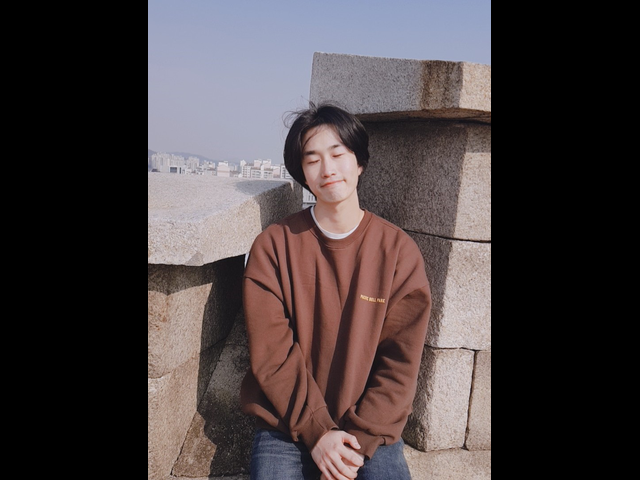

In [ ]:
pil_image = Image.open('./examples/example.jpg')

if pil_image.mode == 'RGBA':
    pil_image = pil_image.convert('RGB')

resized_pil_image = resize_image(pil_image, (640, 480))
resized_pil_image

In [ ]:
# Example usage
TASK = 'pose'
VERSION = 'sapiens_0.3b'

model_path = get_model_path(TASK, VERSION)
print(model_path)

checkpoints/pose_coco/sapiens_0.3b_torchscript.pt2


In [9]:
model = torch.jit.load(model_path)
model.eval()
model.to("cuda")

RecursiveScriptModule(
  original_name=TopdownPoseEstimator
  (data_preprocessor): RecursiveScriptModule(original_name=PoseDataPreprocessor)
  (backbone): RecursiveScriptModule(
    original_name=VisionTransformer
    (patch_embed): RecursiveScriptModule(
      original_name=PatchEmbed
      (projection): RecursiveScriptModule(original_name=Conv2d)
    )
    (drop_after_pos): RecursiveScriptModule(original_name=Dropout)
    (layers): RecursiveScriptModule(
      original_name=ModuleList
      (0): RecursiveScriptModule(
        original_name=TransformerEncoderLayer
        (ln1): RecursiveScriptModule(original_name=LayerNorm)
        (attn): RecursiveScriptModule(
          original_name=MultiheadAttention
          (qkv): RecursiveScriptModule(original_name=Linear)
          (proj): RecursiveScriptModule(original_name=Linear)
          (proj_drop): RecursiveScriptModule(original_name=Dropout)
          (out_drop): RecursiveScriptModule(original_name=DropPath)
          (gamma1): Recur

In [15]:
output_pose = get_pose(resized_pil_image, model)

In [ ]:
result = Image.fromarray(output_pose)

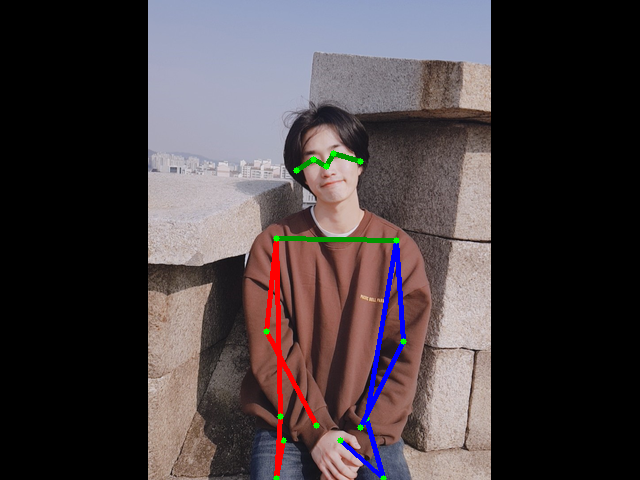

In [ ]:
result